In [1]:
# Dataloading Stuff
from google.colab import drive
import sys
import os
import operator
import collections
from importlib import reload


# Standard Stuff
!pip3 install numpy sklearn iterative-stratification pandas pyss3
from sklearn.model_selection import train_test_split
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from pyss3 import SS3
from pyss3.util import Dataset, Evaluation, span

import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
import pandas as pd

!pip3 install nltk
from nltk import word_tokenize, sent_tokenize, download
download('punkt')

drive.mount('/content/drive', force_remount=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Mounted at /content/drive


In [2]:
!rm -rf vocab_city 
!mkdir vocab_city

In [3]:
path_root = '/content/drive/My Drive/NLP Lab/SingleLabel'
vocab_root = '/Notebooks/Experiments/word-cloud/vocab_city'
sys.path.append(path_root)
data_root = '/data/'

In [4]:
import util

In [5]:
with open(path_root + data_root + 'CityReview/test.txt', 'r') as text_file:
  text = text_file.read().split('\n')

with open(path_root + data_root + 'CityReview/test_label.txt', 'r') as label_file:
  labels = label_file.read().split('\n')
del text[-1]
del labels[-1]
X_train, X_val, y_train, y_val = train_test_split(text, labels, test_size=0.2)

In [6]:
def rename_labels(gold):
    for i,label in enumerate(gold):
        gold[i] = label.split()[0]
#     return temp


def avg_important_word_number(samples, labels, vocab, threshold):
    size = 0
    for i, sample in enumerate(samples):
        
        # if(i%1000==0):
        #     print(i)
            
        df = vocab[labels[i] + '_' + 'words']
        for word in word_tokenize(sample):
            try:
                if df[df.term == word].iloc[0,3] > threshold:
                    size += 1
            except IndexError:
                    size += 0 
    return size / len(samples)

def __false_negative_words__(clf, categories, X_val, y_val, vocab):
    
    ## clf: model
    ## categories: list of classses
    ## X_val
    ## y_val
    ## vocab: dict of cat as keys and dataframe as vocab learned by the model for that class
    
    ## return
    ## fn_word: dict with keys as class and values as FN and word
    ##          FN: dict with keys as fals negative classes and all sentences and important words as keys
    ##          word: df of all fn_words with their gv and fn_class
    
    predict = clf.predict(X_val)
    fn_word = {}
    for cat in categories:
        class_vocab = vocab[cat+ "_words"].set_index('term', inplace=False)
        FN = collections.defaultdict(list)
        word = []
        for i, label in enumerate(y_val):
            if label == cat and predict[i] != cat:
                sentence = X_val[i].split()
                top_words = clf.extract_insight(X_val[i], predict[i],window_size=0)
                FN_word_sentence = []
                for top_word in list(set(top_words)):
                    insert = [X_val[i]]
                    insert.extend([top_word[0], top_word[1], predict[i], sentence.count(top_word[0])])
                    try:
                        insert.append(class_vocab.loc[top_word[0], 'gv'])
                    except KeyError:
                        insert.append("word not in vocab of "+ cat)
                    word.append(insert)
                    FN_word_sentence.append(insert)
                FN[predict[i]].append(FN_word_sentence)
        fn_word[cat] = (dict(FN),pd.DataFrame(word, columns =['sentence', 'fn_word', 'gv', 'fn_class', 'count', 'gv_trueclass']))
    return fn_word
    

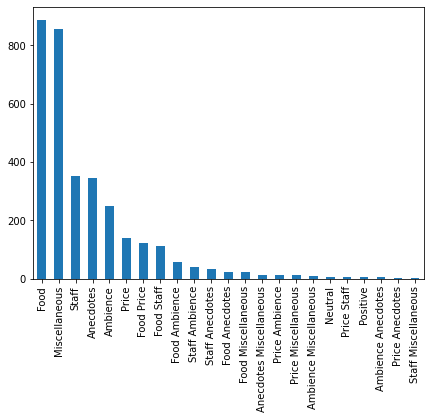

In [7]:
pd.Series(labels).value_counts().plot(kind ='bar', figsize=(7,5))

Training on 'Staff Miscellaneous': 100%|██████████| 23/23 [00:00<00:00, 64.24it/s]



                         precision    recall  f1-score   support

               Ambience       0.61      0.49      0.54        41
     Ambience Anecdotes       0.00      0.00      0.00         1
 Ambience Miscellaneous       0.00      0.00      0.00         1
              Anecdotes       0.39      0.66      0.49        64
Anecdotes Miscellaneous       0.00      0.00      0.00         1
                   Food       0.70      0.45      0.55       200
          Food Ambience       0.33      0.09      0.14        11
         Food Anecdotes       0.00      0.00      0.00         7
     Food Miscellaneous       0.04      0.33      0.07         3
             Food Price       0.23      0.28      0.25        25
             Food Staff       0.11      0.11      0.11        19
          Miscellaneous       0.53      0.55      0.54       171
                Neutral       0.00      0.00      0.00         0
               Positive       0.70      0.21      0.33        33
                  Price

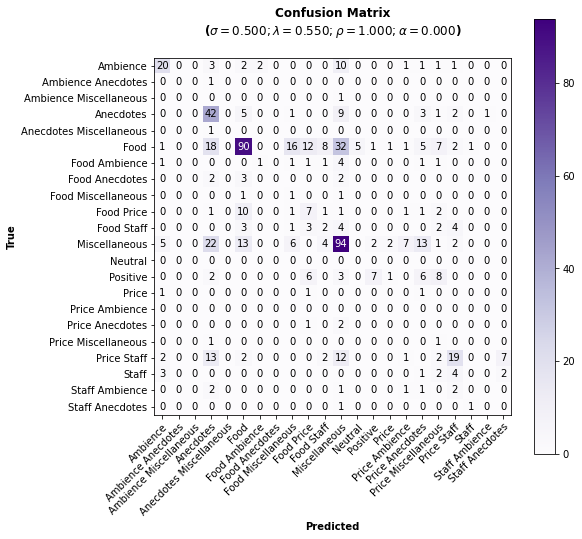

0.15095514320035225

In [8]:
clf = SS3(s=0.5, l=0.55,a=0)
clf.fit(X_train, y_train)
Evaluation.test(clf, X_val, y_val, metric="f1-score")

In [9]:
clf.print_categories_info()
clf.save_vocab(path='./vocab_city')



 CATEGORIES:

	       Category         | Index |   Length   | Vocab. Size | Word Max. Fr. | N-gram |
	------------------------|-------|------------|-------------|---------------|--------|
	       Ambience         |   0   |    3211    |     939     |      199      |   1    |
	  Ambience Anecdotes    |   1   |     63     |     49      |       4       |   1    |
	Ambience Miscellaneous  |   2   |    134     |     99      |      10       |   1    |
	       Anecdotes        |   3   |    4518    |    1044     |      193      |   1    |
	Anecdotes Miscellaneous |   4   |    189     |     112     |      12       |   1    |
	         Food           |   5   |   10234    |    2038     |      780      |   1    |
	     Food Ambience      |   6   |    988     |     421     |      73       |   1    |
	    Food Anecdotes      |   7   |    380     |     221     |      19       |   1    |
	  Food Miscellaneous    |   8   |    327     |     189     |      22       |   1    |
	      Food Price        | 

In [10]:
vocab = {}
categories = list(set(labels))
grams = ["words"]
for gram in grams:
  for cat in categories:
    try:
      vocab[cat + '_' + gram] = pd.read_csv("/content/vocab_city/ss3_vocab_"+ cat +"(" + gram + ").csv")
    except FileNotFoundError as e:
      print("File not found for", cat)

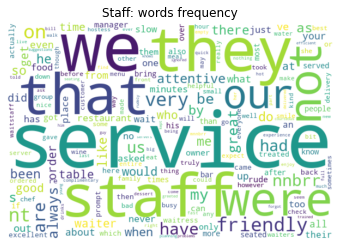

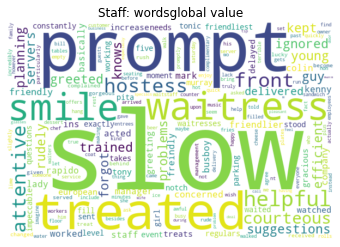

In [11]:
cat = "Staff"
for gram in ["words"]:
    for col in ["fr", "gv"]:
        df = vocab[cat + '_' + gram]
        df1 = df[["term",col]]
        count = df1.set_index('term').T.to_dict('records')[0]

        wordcloud = WordCloud(height =400,width = 600,max_font_size = 200,background_color="white").generate_from_frequencies(count)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.title(cat + ": " + gram + " frequency") if col == "fr" else plt.title(cat + ": " + gram + "global value")
        plt.axis("off")
        plt.show()

In [12]:
for cat in categories:
  for gram in ["words"]:
    try:
      df = vocab[cat + '_' + gram]
    except KeyError as e:
      # print(cat,"_", gram ,": NO FILE")
      print("")
    else:
      above_threshold = df[df.gv > 0.2].count()["term"]
      total = df.describe()["fr"]["count"]
      percentage = (above_threshold/total)*100
      print(cat,"_", gram ,":         percentage=", round(percentage,2),", above threshold=", above_threshold,", total=", total)
  print("            ")  
# vocab['Staff Anecdotes_words']

Food Miscellaneous _ words :         percentage= 0.0 , above threshold= 0 , total= 27.0
            
Price Anecdotes _ words :         percentage= 0.0 , above threshold= 0 , total= 3.0
            
Positive _ words :         percentage= 33.33 , above threshold= 1 , total= 3.0
            
Price Miscellaneous _ words :         percentage= 0.0 , above threshold= 0 , total= 17.0
            
Staff _ words :         percentage= 0.0 , above threshold= 0 , total= 434.0
            
Food Staff _ words :         percentage= 0.0 , above threshold= 0 , total= 170.0
            
Food Ambience _ words :         percentage= 0.0 , above threshold= 0 , total= 103.0
            
Staff Ambience _ words :         percentage= 0.0 , above threshold= 0 , total= 62.0
            
Food Anecdotes _ words :         percentage= 4.76 , above threshold= 2 , total= 42.0
            
Neutral _ words :         percentage= 0.0 , above threshold= 0 , total= 8.0
            
Price _ words :         percentage= 0.0 , ab

In [13]:
# important_words = avg_important_word_number(X_train, y_train, vocab, 0.2)

In [14]:
words = util.avg_word_number(X_train, y_train)

In [15]:
# print("percentage of average important words per sample: ", (important_words/words)*100)

In [16]:
fn_word = __false_negative_words__(clf, categories, X_val, y_val, vocab)

Classification: 100%|██████████| 666/666 [00:00<00:00, 46233.14it/s]


In [17]:
true_class = 'Staff'
fn_class = 'Food'
## word frequency in false_negative class ##
a = fn_word[true_class][1]
b = a[a.fn_class == fn_class].groupby(['fn_word','fn_class'], as_index=False).agg({'count': sum}).sort_values('count', ascending=False)
b

,fn_word,fn_class,count
26,were,Food,3
0,They,Food,2
22,they,Food,2
1,actually,Food,1
28,while,Food,1
27,when,Food,1
25,very,Food,1
24,up,Food,1
23,tuna,Food,1
21,some,Food,1


In [18]:
a[a.fn_class == fn_class].sentence.unique()

array([' The servers give you some sample slices of your order while you wait ( shortly I might add ) . ',
       ' We both opted for a pasta dish and they were served timely and fresh . ',
       ' They showed up 15 minutes after the tuna melt . ',
       ' They were very abrupt with me when I called and actually claimed the food was late because they were out of rice . '],
      dtype=object)

In [23]:
a[(a.sentence == ' They showed up 15 minutes after the tuna melt . ')].sort_values('gv', ascending=False)

,sentence,fn_word,gv,fn_class,count,gv_trueclass
137,They showed up 15 minutes after the tuna melt .,tuna,0.661077,Food,1,word not in vocab of Staff
134,They showed up 15 minutes after the tuna melt .,melt,0.292456,Food,1,word not in vocab of Staff
135,They showed up 15 minutes after the tuna melt .,They,0.086545,Food,1,word not in vocab of Staff
136,They showed up 15 minutes after the tuna melt .,after,0.066067,Food,1,0.020996
133,They showed up 15 minutes after the tuna melt .,up,0.056499,Food,1,0.017034


In [20]:
c = b[['fn_word','count']].set_index('fn_word', inplace=False)
true_vocab = vocab[true_class + '_words'].sort_values('gv', ascending=False).set_index('term', inplace=False)
false_vocab = vocab[fn_class + '_words'].sort_values('gv', ascending=False).set_index('term', inplace=False)

result = pd.concat([c, false_vocab, true_vocab], axis=1, sort=False)

In [21]:
result.columns = ['count', fn_class +'_fr', fn_class +'_gv', fn_class +'_cv', true_class +'_fr', true_class +'_gv', true_class +'_cv']
result[(~result['count'].isnull()) & (result[fn_class +'_gv'] > result[true_class + '_gv'])]


,count,Food_fr,Food_gv,Food_cv,Staff_fr,Staff_gv,Staff_cv
while,1.0,12.0,0.008758,0.051400,3.0,0.007073,0.036970
some,1.0,22.0,0.014286,0.083842,6.0,0.012050,0.062988
rice,1.0,22.0,0.036207,0.212485,2.0,0.017631,0.092161
food,1.0,149.0,0.043199,0.253518,11.0,0.000001,0.000003
dish,1.0,17.0,0.019003,0.111520,2.0,0.010527,0.055025
both,1.0,14.0,0.013912,0.081647,2.0,0.008493,0.044392
because,1.0,9.0,0.013803,0.081007,3.0,0.012872,0.067281


In [22]:
result[~result['count'].isnull()]

,count,Food_fr,Food_gv,Food_cv,Staff_fr,Staff_gv,Staff_cv
were,3.0,69.0,0.014739,0.086498,39.0,0.017897,0.093551
They,2.0,NaN,NaN,NaN,NaN,NaN,NaN
they,2.0,69.0,0.014747,0.086545,50.0,0.020276,0.105983
actually,1.0,8.0,0.021817,0.128036,7.0,0.032962,0.172294
while,1.0,12.0,0.008758,0.051400,3.0,0.007073,0.036970
when,1.0,9.0,0.007585,0.044515,16.0,0.016343,0.085426
very,1.0,45.0,0.003342,0.019613,31.0,0.024229,0.126648
up,1.0,10.0,0.009627,0.056499,12.0,0.017034,0.089036
tuna,1.0,10.0,0.112645,0.661077,NaN,NaN,NaN
some,1.0,22.0,0.014286,0.083842,6.0,0.012050,0.062988


**ALL METRICS**

In [ ]:
!rm -rf vocab && mkdir vocab
util = reload(util)
print("Avg Number of Sentences", util.avg_sent_number(X_train, y_train))
print("Avg Number of Paragraphs", util.avg_para_number(X_train, y_train))
overlap, counter, ratio = util.calc_overlap(clf, './vocab', 'fr')
print("Overlap Ratio All Words", ratio)

!rm -rf vocab_five && mkdir vocab_five
overlap, counter, ratio = util.calc_overlap(clf, './vocab', 'gv', True, 0.2)
print("Overlap Ratio Important Words", ratio)

Avg Number of Sentences 1.0822689706987227
Avg Number of Paragraphs 1.0
Overlap Ratio All Words 0.45051903114186853
Overlap Ratio Important Words 0.0


In [ ]:
clf.classify_label("Only drawback - they wo n't toast your bagel , and they do n't make eggs for the bagel .")
clf.extract_insight("Only drawback - they wo n't toast your bagel , and they do n't make eggs for the bagel .", cat='Staff', window_size=0)

[('toast', 0.449511457184981),
 ('they', 0.34400249406569217),
 ('they', 0.34400249406569217),
 ("n't", 0.1804845427921845),
 ("n't", 0.1804845427921845),
 ('wo', 0.16694940679072512),
 ('make', 0.1374485462381268),
 ('bagel', 0.13618049549273845),
 ('bagel', 0.13618049549273845),
 ('do', 0.11490446020772715),
 ('your', 0.07795161363375373),
 ('Only', 0.04994275414307329)]